In [3]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from shapely import geometry
import osmnx as ox
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
#from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
#from syspy.spatial.graph import graphbuilder
#from quetzal.io.gtfs_reader import importer
#from quetzal.model import stepmodel

In [4]:
training_folder = 'D:/Grandfinale/Term_Paper/'
input_folder = training_folder + r'data/'

## Zones

Load zone data from the input files

C:\Users\j_sen\AppData\Local\Temp/ipykernel_14464/3630326768.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull = zones["geometry"].buffer(1e-3).unary_union


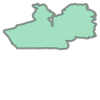

In [5]:
zones = gpd.read_file(r'../data/zonesv1.geojson')
hull = zones["geometry"].buffer(1e-3).unary_union
#geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

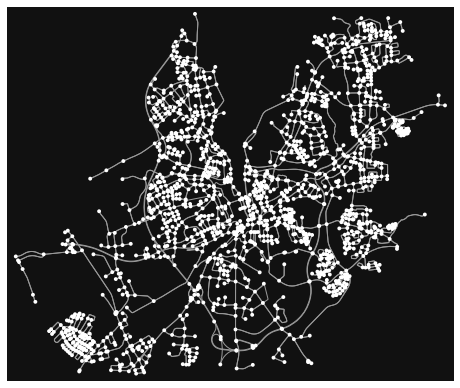

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
ox.plot_graph(drive)

In [7]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [8]:
# Let's have a look at the results
road_nodes.head(2)

,y,x,street_count,highway,geometry
osmid,,,,,
26012989,54.761671,9.396664,3,NaN,POINT (9.39666 54.76167)
26012995,54.755484,9.402495,4,traffic_signals,POINT (9.40250 54.75548)


In [9]:
road_links.head(2)

osmid lanes   ref        name  \
u        v         key                                                 
26012989 654163464 0                79258351     2  K 27   Ochsenweg   
         654163515 0    [79263955, 51269724]   NaN   NaN  Hooger Weg   

                            highway maxspeed  oneway   length  \
u        v         key                                          
26012989 654163464 0      secondary       30   False  183.731   
         654163515 0    residential       30   False  275.879   

                                                                 geometry  \
u        v         key                                                      
26012989 654163464 0    LINESTRING (9.39666 54.76167, 9.39697 54.76126...   
         654163515 0    LINESTRING (9.39666 54.76167, 9.39708 54.76178...   

                       bridge junction access tunnel width  
u        v         key                                      
26012989 654163464 0      NaN      NaN    NaN    NaN   NaN  
         654163515 0      NaN      NaN    NaN    NaN   NaN

<AxesSubplot:>

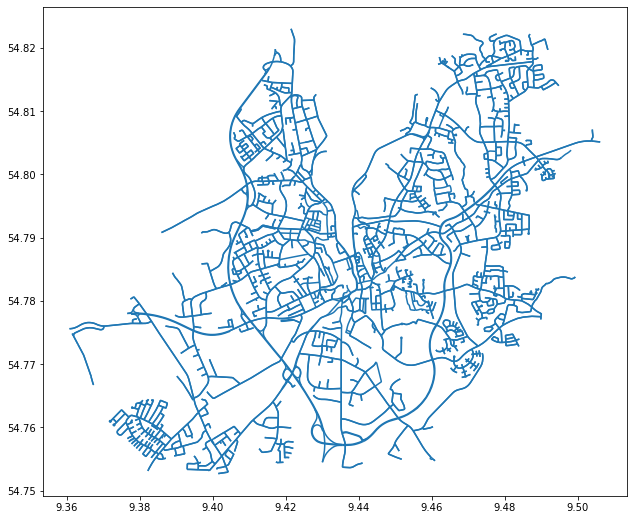

In [10]:
road_links.plot(figsize=(16,9))

In [11]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [12]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

KeyError: 'osmid'

In [11]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [12]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [13]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [14]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path=input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

In [15]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
feed_r = full_feed.restrict(
    dates=['20200204'] # the dates must be within the feed start and end dates
)

In [16]:
# We can also restrict it to hours
time_range = ['08:00:00', '09:00:00'] 
feed_t = feed_r.restrict(time_range=time_range)

In [17]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [18]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [19]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_s.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|████████████████████████████████████████████████████████████████████████████████| 388/388 [00:09<00:00, 39.69it/s]


In [20]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32631


In [21]:
feed_frequencies.links.head(2)

,index,a,trip_id,link_sequence,departure_time,pickup_type,b,arrival_time,drop_off_type,time,...,shape_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,geometry
0,0,StopPoint:14:14934,098098001:DIRECT1_0,1,27600.0,0,StopPoint:14:14976,27900.0,0,300.0,...,NaN,896,DIRECT 1,LE BUS DIRECT 1,NaN,3,NaN,B20066,ffffff,"LINESTRING (2.29451 48.87432, 2.28651 48.86277)"
1,1,StopPoint:14:14976,098098001:DIRECT1_0,2,27900.0,0,StopPoint:14:410,29100.0,0,1200.0,...,NaN,896,DIRECT 1,LE BUS DIRECT 1,NaN,3,NaN,B20066,ffffff,"LINESTRING (2.28651 48.86277, 2.32054 48.83929)"


In [22]:
feed_frequencies.nodes.head(1)

,stop_id,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,geometry
315,StopArea:8738102,PORTE MAILLOT,NaN,NaN,NaN,1,NaN,NaN,POINT (2.28258 48.87812)


In [23]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

0

In [24]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

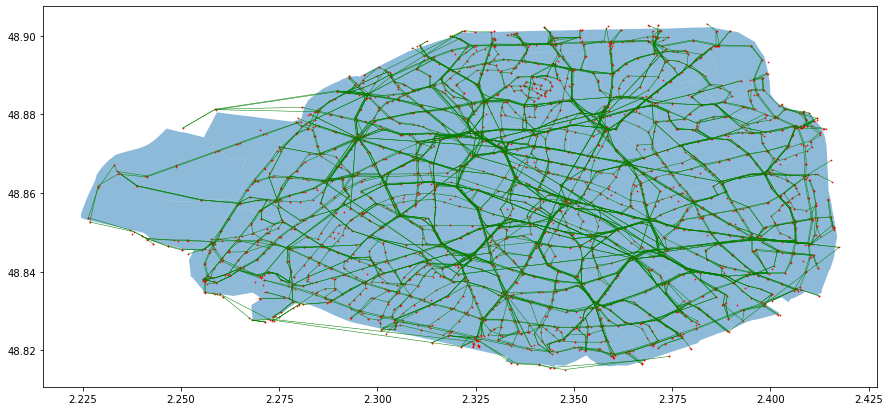

In [25]:
# Plot the results using matplotlib notation
ax = zones.plot(alpha=0.5, figsize=[17, 7])
ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [26]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')

In [27]:
# Save zones into the model
sm.zones = zones

In [28]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']]
sm.road_nodes = oc.nodes[['geometry']]

In [29]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'route_color', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [30]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [31]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 10328it [00:04, 2289.66it/s]
reversed: 10328it [00:04, 2387.68it/s]
10115it [00:04, 2412.94it/s]


In [32]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['100100290:290_1', '100100323:323_1']


In [33]:
# Test
sm.integrity_test_all(errors='raise')

967it [00:00, 9530.09it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision


10115it [00:00, 10590.13it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


10115it [00:04, 2444.13it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.

In [34]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=300)
sm.nodes.head(1)

,geometry
cluster,
0,POINT (2.323312216247907 48.87907725686767)


In [50]:
len(sm.nodes)

300

In [37]:
# Now, some links might go from one stop to the same
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]

In [40]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

dropped circular lines: ['100100030:30_1', '100100040:40_1', '100100054:54_0', '100100137:137_1', '100100518:BATIGNO_0', '100100341:341_1', '100100513:BIEVRES_0', '100100088:88_1', '100100519:NEY-FLA_0', '100100501:CHARONN_0', '100100080:80_0', '100100069:69_3', '100100093:93_0', '100100071:71_0', '100100022:22_1', '100100054:54_3', '100100042:42_1', '100100093:93_2', '100100080:80_1', '100100071:71_1', '100100077:77_0', '333575515:TRAVERSE_0', '100100031:31_1']
dropped broken sequences: []


In [41]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

1304it [00:00, 12915.03it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision


10115it [00:00, 14330.28it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


10115it [00:03, 3163.78it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [51]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [52]:
sm.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,geometry,disaggregated_a,disaggregated_b
index,,,,,,,,,,,,,,,,
link_1976,100100066:66_2,n_209,n_57,6,120.0,720.0,100100066:66_2,100100066:66,6706,0,442,bus,00643C,"LINESTRING (2.31610 48.88894, 2.31827 48.89120)",node_StopPoint:59:4472776,node_StopPoint:59:5018164


## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [53]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

,a,b,geometry,length,voronoi,time
footpath_0,n_101,n_182,LINESTRING (2.408428793707524 48.8350805964043...,819.179779,1,983.015735
footpath_1,n_101,n_192,LINESTRING (2.408428793707524 48.8350805964043...,504.153006,1,604.983608
footpath_2,n_101,n_246,LINESTRING (2.408428793707524 48.8350805964043...,768.753250,1,922.503900


In [54]:
len(sm.footpaths)

1608

In [55]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [60]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
ztt_132,zone_19,n_124,access,390.088029,LINESTRING (2.319977351022223 48.8717525779581...,1,1.396582,3,7,4.189745,335.179582,335.179582


In [61]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
ztr_268,zone_48,15859494,access,202.875553,LINESTRING (2.367272562518094 48.8387198329797...,2,1.007163,3,7,3.02149,241.719175,241.719175


In [62]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
rtt_942,n_73,235830506,access,46.731765,LINESTRING (2.364603952099257 48.8437561735920...,3,0.483383,3,7,3.0,56.078118,56.078118


## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [63]:
sm.to_json('../../model/network')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  4.79it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values
could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes
